<a href="https://colab.research.google.com/github/BenyFridd/M4_SPRINTS/blob/main/detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -m pip install pyyaml==5.1

!pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Outras bibliotecas úteis
!pip install opencv-python
!pip install matplotlib

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-mhg8e90u
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-mhg8e90u
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done


In [ ]:
from PIL import Image
import os

# Caminho para o diretório de imagens
image_dir = '/content/drive/MyDrive/cattle_dataset'

# Definir o tamanho esperado
expected_size = (128, 128)

# Extensões de arquivo de imagem comuns
image_extensions = ['.png', '.jpg', '.jpeg']

# Loop por todas as imagens no diretório
for image_name in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_name)

    # Verifique se o arquivo é uma imagem com base na extensão
    if os.path.splitext(image_name)[1].lower() in image_extensions:
        try:
            # Abra a imagem
            with Image.open(image_path) as img:
                if img.size != expected_size:
                    print(f"Redimensionando {image_name} de {img.size} para {expected_size}")
                    img = img.resize(expected_size)
                    img.save(image_path)
        except Exception as e:
            print(f"Erro ao abrir a imagem {image_name}: {e}")
    else:
        print(f"Arquivo ignorado (não é uma imagem): {image_name}")

print("Redimensionamento completo!")


Redimensionando image_2798.png de (128, 127) para (128, 128)
Redimensionando image_245.png de (128, 127) para (128, 128)
Arquivo ignorado (não é uma imagem): test_coco.json
Redimensionando image_752.png de (128, 127) para (128, 128)
Redimensionando image_711.png de (127, 128) para (128, 128)
Redimensionando image_763.png de (127, 128) para (128, 128)
Redimensionando image_716.png de (127, 128) para (128, 128)
Redimensionando image_661.png de (127, 128) para (128, 128)
Arquivo ignorado (não é uma imagem): train_coco.json
Redimensionando image_542.png de (128, 127) para (128, 128)
Redimensionamento completo!


In [ ]:
import os
import json

# Caminho para os seus JSONs de train e test
train_json_path = '/content/drive/MyDrive/cattle_dataset/train_coco.json'
test_json_path = '/content/drive/MyDrive/cattle_dataset/test_coco.json'

# Função para atualizar as dimensões no JSON
def update_image_dimensions(json_path, correct_width, correct_height):
    # Carregar o JSON existente
    with open(json_path, 'r') as f:
        coco_data = json.load(f)

    # Atualizar as dimensões de cada imagem no JSON
    for image_info in coco_data['images']:
        # Corrigir as dimensões para todas as imagens
        if image_info['width'] != correct_width or image_info['height'] != correct_height:
            print(f"Corrigindo tamanho para {image_info['file_name']}: de ({image_info['width']}, {image_info['height']}) para ({correct_width}, {correct_height})")
            image_info['width'] = correct_width
            image_info['height'] = correct_height

    # Salvar o arquivo JSON atualizado
    updated_json_path = json_path.replace('.json', '_updated.json')
    with open(updated_json_path, 'w') as f:
        json.dump(coco_data, f)

    print(f"JSON atualizado salvo em {updated_json_path}")

# Definir as dimensões corretas (128x128)
correct_width = 128
correct_height = 128

# Atualizar os JSONs de treinamento e teste
update_image_dimensions(train_json_path, correct_width, correct_height)
update_image_dimensions(test_json_path, correct_width, correct_height)

print("Dimensões atualizadas para os arquivos JSON de train e test.")


Corrigindo tamanho para image_2798.png: de (128, 127) para (128, 128)
JSON atualizado salvo em /content/drive/MyDrive/cattle_dataset/train_coco_updated.json
Corrigindo tamanho para image_245.png: de (128, 127) para (128, 128)
Corrigindo tamanho para image_542.png: de (128, 127) para (128, 128)
Corrigindo tamanho para image_661.png: de (127, 128) para (128, 128)
Corrigindo tamanho para image_711.png: de (127, 128) para (128, 128)
Corrigindo tamanho para image_716.png: de (127, 128) para (128, 128)
Corrigindo tamanho para image_752.png: de (128, 127) para (128, 128)
Corrigindo tamanho para image_763.png: de (127, 128) para (128, 128)
JSON atualizado salvo em /content/drive/MyDrive/cattle_dataset/test_coco_updated.json
Dimensões atualizadas para os arquivos JSON de train e test.


In [ ]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

# Registrar os datasets de treino e teste
train_json = '/content/drive/MyDrive/cattle_dataset/train_coco.json'
test_json = '/content/drive/MyDrive/cattle_dataset/test_coco.json'
image_dir = '/content/drive/MyDrive/cattle_dataset'

# Registrar o dataset em formato COCO no Detectron2
register_coco_instances("cattle_train", {}, train_json, image_dir)
register_coco_instances("cattle_test", {}, test_json, image_dir)

# Verificar se o dataset foi registrado corretamente
metadata = MetadataCatalog.get("cattle_train")
dataset_dicts = DatasetCatalog.get("cattle_train")

print("Dataset registrado com sucesso!")


[09/18 18:30:33 d2.data.datasets.coco]: Loaded 3084 images in COCO format from /content/drive/MyDrive/cattle_dataset/train_coco.json
Dataset registrado com sucesso!


In [ ]:
import detectron2
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os
# Configuração do modelo
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("cattle_train",)
cfg.DATASETS.TEST = ("cattle_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Pesos pré-treinados no COCO
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0001  # Taxa de aprendizado
cfg.SOLVER.MAX_ITER = 1500    # Número de iterações de treinamento (ajuste conforme necessário)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32   # Este é o batch size padrão
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Temos apenas uma classe (face do gado)

# Salvar os pesos do modelo treinado
cfg.OUTPUT_DIR = "/content/drive/MyDrive/detectron2_output"

# Iniciar o treinamento
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[09/18 18:53:06 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

  pixel_mean
  pixel_std


[09/18 18:53:07 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/18 18:53:14 d2.utils.events]:  eta: 0:11:40  iter: 19  total_loss: 1.303  loss_cls: 0.7722  loss_box_reg: 0.5519    time: 0.3619  last_time: 0.3349  data_time: 0.0271  last_data_time: 0.0070   lr: 4.9953e-06  max_mem: 3512M
[09/18 18:53:21 d2.utils.events]:  eta: 0:11:21  iter: 39  total_loss: 1.195  loss_cls: 0.6122  loss_box_reg: 0.5613    time: 0.3541  last_time: 0.3383  data_time: 0.0073  last_data_time: 0.0058   lr: 9.9902e-06  max_mem: 3512M
[09/18 18:53:28 d2.utils.events]:  eta: 0:11:21  iter: 59  total_loss: 0.9416  loss_cls: 0.412  loss_box_reg: 0.533    time: 0.3583  last_time: 0.3148  data_time: 0.0122  last_data_time: 0.0072   lr: 1.4985e-05  max_mem: 3512M
[09/18 18:53:36 d2.utils.events]:  eta: 0:11:18  iter: 79  total_loss: 0.8309  loss_cls: 0.3571  loss_box_reg: 0.4876    time: 0.3632  last_time: 0.2666  data_time: 0.0067  last_data_time: 0.0056   lr: 1.998e-05  max_mem: 3512M
[09/18 18:53:43 d2.utils.events]:  eta: 0:11:14  iter: 99  total_loss: 0.6898  loss_cls: 

[09/18 19:07:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/detectron2_output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

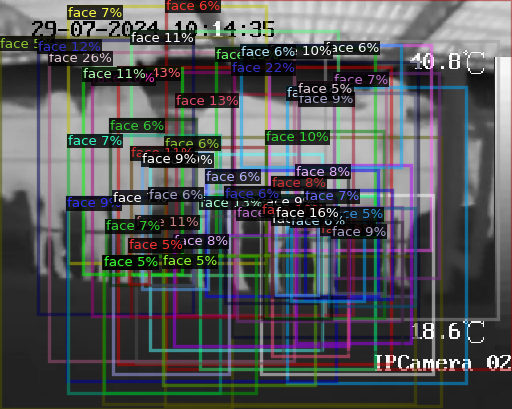

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
import cv2
from google.colab.patches import cv2_imshow  # Import para Colab

# Configuração do predictor para fazer inferências
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Pesos finais do modelo treinado
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Definir um threshold
predictor = DefaultPredictor(cfg)

# Carregar uma nova imagem para testar
image_path = "/content/imagemteste.png"
im = cv2.imread(image_path)

# Fazer inferência
outputs = predictor(im)

# Visualizar o resultado
v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])
